### Realistic use case for data with at least three classes
- Sentiment analysis for product feedback
- Recommendation systems for customers
- Fake review detection and classification

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import utils

## Data Processing

In [2]:
file_path = 'Amazon-Product-Reviews.csv'

In [3]:
# Load the dataset
df = pd.read_csv(file_path)

In [4]:
# Load basic info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30846 entries, 0 to 30845
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        30846 non-null  int64 
 1   review_id          30846 non-null  object
 2   product_parent     30846 non-null  int64 
 3   product_title      30846 non-null  object
 4   star_rating        30846 non-null  int64 
 5   total_votes        30846 non-null  int64 
 6   verified_purchase  30846 non-null  object
 7   review_headline    30846 non-null  object
 8   review_body        30846 non-null  object
 9   review_date        30846 non-null  object
 10  sentiment          30846 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 2.6+ MB


In [5]:
# Display the first few rows of the dataset
df.head()

,customer_id,review_id,product_parent,product_title,star_rating,total_votes,verified_purchase,review_headline,review_body,review_date,sentiment
0,11555559,R1QXC7AHHJBQ3O,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",5,0,Y,Five Stars,Great love it,8/31/2015,1
1,31469372,R175VSRV6ZETOP,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",3,0,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,8/31/2015,0
2,26843895,R2HRFF78MWGY19,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",5,0,Y,Well thought out device,Excellent unit. The versatility of this table...,8/31/2015,1
3,19844868,R8Q39WPKYVSTX,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",4,0,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,8/31/2015,1
4,1189852,R3RL4C8YP2ZCJL,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",5,0,Y,Five Stars,All Amazon products continue to meet my expect...,8/31/2015,1


In [6]:
# Check if  there is missing data in the dataset
df.isnull().sum()

customer_id          0
review_id            0
product_parent       0
product_title        0
star_rating          0
total_votes          0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
sentiment            0
dtype: int64

## Analyzing dataset features

In [7]:
# Convert Y/N value of verified_purchase into boolean value
df['verified_purchase'] = df['verified_purchase'].apply(lambda x: 1 if x == 'Y' else 0)

In [8]:
# Get the length of reviews body and headline
df['review_headline_length'] = df['review_headline'].apply(len)
df['review_body_length'] = df['review_body'].apply(len)

In [9]:
# Get the year of reviews
df['review_year'] = pd.to_datetime(df['review_date']).dt.year

In [10]:
# Display the dataset after analysis and data type conversion
df[['verified_purchase', 'review_headline_length', 'review_body_length', 'review_year']].head()

,verified_purchase,review_headline_length,review_body_length,review_year
0,1,10,13,2015
1,0,66,171,2015
2,1,23,654,2015
3,0,121,1106,2015
4,1,10,52,2015


## Bar graph showing the count of each class

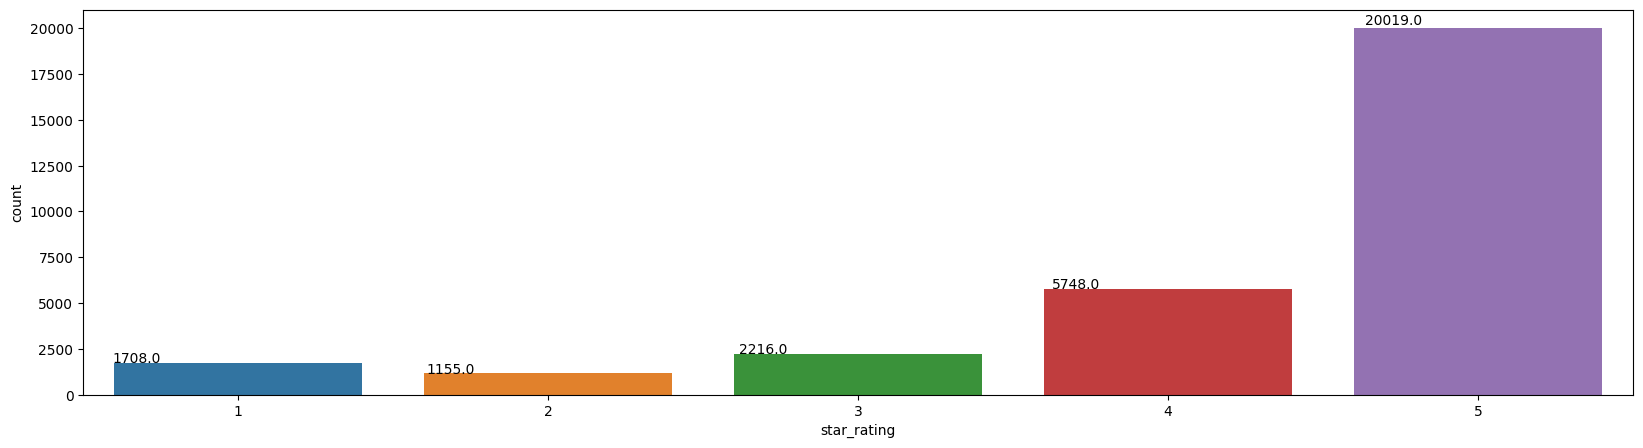

In [11]:
plt.figure(figsize=(20,5))
ax1=sns.countplot(x="star_rating", data=df)
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.show()

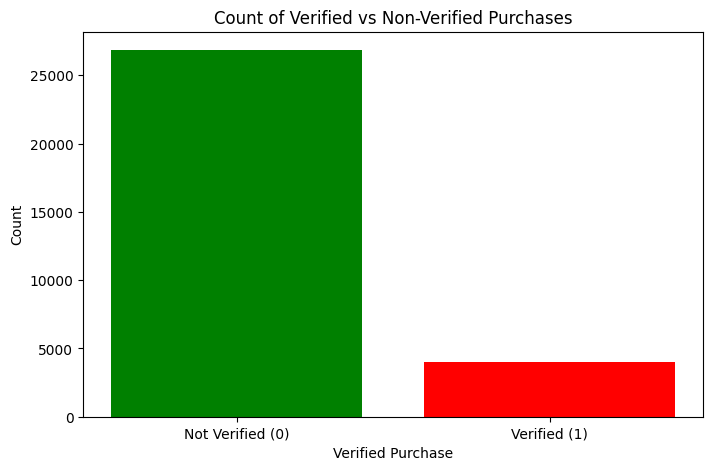

In [12]:
# Count verified_purchase frencuencies
verified_purchase_counts = df['verified_purchase'].value_counts()
# Create bar chart
plt.figure(figsize=(8, 5))
plt.bar(verified_purchase_counts.index.astype(str), verified_purchase_counts.values, color=['green', 'red'])
# Set title and label for the bar chart
plt.title('Count of Verified vs Non-Verified Purchases')
plt.xlabel('Verified Purchase')
plt.ylabel('Count')
# Label for x-axis
plt.xticks(ticks=[0, 1], labels=['Not Verified (0)', 'Verified (1)'])
# Draw the bar chart
plt.show()

## Split data into training(70%), testing data and validation data(30%)

In [13]:
print("Before : {}".format(len(df)))
dataAfter = df.dropna(subset=["star_rating"])
# Removes all NAN in reviews.rating
print("After  : {}".format(len(dataAfter)))
dataAfter["reviews.rating"] = dataAfter["star_rating"].astype(int)

split = StratifiedShuffleSplit(n_splits=10, test_size=0.2)
for train_index, test_index in split.split(dataAfter,
                                           dataAfter["star_rating"]):
    strat_train = dataAfter.reindex(train_index)
    strat_test = dataAfter.reindex(test_index)

Before : 30846
After  : 30846


In [14]:
# Check the size of and training and testing data
print(len(strat_train))
print(len(strat_test))
round((strat_test["star_rating"].value_counts()* 100/len(strat_test)),2)

24676
6170


5    64.89
4    18.64
3     7.18
1     5.54
2     3.74
Name: star_rating, dtype: float64

In [15]:
# Define features and target
X = df[['verified_purchase', 'review_headline_length', 'review_body_length', 'review_year']]
y = df['star_rating']

In [16]:
# Split data into 70% training and 30% testing and validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
# Splitting 50/50 for the temp validation and testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Data Analysis

In [18]:
reviews = strat_train.copy()

In [19]:
reviews["reviews.rating"].mean()

4.336197114605285

In [20]:
# Define features and target
X = df[['verified_purchase', 'review_headline_length', 'review_body_length', 'review_year']]
y = df['star_rating']

In [21]:
# Split data into 70% training and 30% testing and validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# Splitting 50/50 for the temp validation and testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Check the size of each dataset

In [23]:
X_train.shape

(21592, 4)

In [24]:
X_val.shape

(4627, 4)

In [25]:
X_test.shape

(4627, 4)

## Gini impurity index decision tree

In [26]:
# Create decision tree model using Gini impurity index
dt_gini = DecisionTreeClassifier(criterion='gini',random_state=42) # No limit for tree depth
dt_gini.fit(X_train, y_train)
gini_train_accuracy = dt_gini.score(X_train, y_train)
gini_val_accuracy = dt_gini.score(X_val, y_val)

In [27]:
gini_train_accuracy

0.8879214523897739

In [28]:
gini_val_accuracy

0.5668899935163173

## Entropy decision tree

In [29]:
# Create decision tree model using Entropy
dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_entropy.fit(X_train, y_train)
entropy_train_accuracy = dt_entropy.score(X_train, y_train)
entropy_val_accuracy = dt_entropy.score(X_val, y_val)

In [30]:
entropy_train_accuracy

0.8879214523897739

In [31]:
entropy_val_accuracy

0.5660255024854117

**On your best decision tree models, use the classification_report and confusion_matrix functions in sklearn to display metrics, using training and validation (but not testing) data. Also use the display¬_tree method in utils.py to display each tree.**

In [32]:
# My best model is the dt_gini model
predictions_gini = dt_gini.predict(X_val)

In [33]:
# The classification_report - Gini Decision Tree
gini_report = classification_report(y_val, predictions_gini)
print(gini_report)

              precision    recall  f1-score   support

           1       0.21      0.23      0.22       241
           2       0.11      0.13      0.12       170
           3       0.26      0.27      0.26       339
           4       0.22      0.15      0.18       844
           5       0.72      0.77      0.74      3033

    accuracy                           0.57      4627
   macro avg       0.30      0.31      0.30      4627
weighted avg       0.55      0.57      0.56      4627



In [34]:
# utils.display_tree(predictions_gini)

In [35]:
# Gini Decision Tree - Confusion Matrix (Validation Data)
gini_con_matrix = confusion_matrix(y_val, predictions_gini)
print(gini_con_matrix)

[[  55   19   30   28  109]
 [  13   22   19   31   85]
 [  28   28   90   57  136]
 [  41   34   69  130  570]
 [ 126  100  143  338 2326]]


### Select and justify your final choice of hyperparameters based on the training and validation metrics. Provide a written analysis in markdown.

#### max_depth=None

I choose to set no limit for the depth of the decision tree, which allows it to capture more features and information about the dataset to get a higher accuracy.

#### min_samples_leaf=10

A smaller minimum number of leaf help the model to capture noise in training data to help improve accuracy.

In [36]:
# New model with chosen hyperparameters
dt_gini_1 = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_leaf=10, random_state=42) # No limit for tree depth
dt_gini_1.fit(X_train, y_train)
gini_train_accuracy_1 = dt_gini_1.score(X_train, y_train)
gini_val_accuracy_1 = dt_gini_1.score(X_val, y_val)

In [37]:
gini_train_accuracy_1

0.69057984438681

In [38]:
gini_val_accuracy_1

0.633455802896045

### Split the data into training, validation, and testing sets. （80%/10%/10%）

In [39]:
# Define features and target
X1 = df[['verified_purchase', 'review_headline_length', 'review_body_length', 'review_year']]
y1 = df['star_rating']
# Split data into 70% training and 30% testing and validation
X_train1, X_temp1, y_train1, y_temp1 = train_test_split(X, y, test_size=0.2, random_state=42)
# Splitting 50/50 for the temp validation and testing
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [40]:
X_train1.shape

(24676, 4)

In [41]:
X_val1.shape

(4627, 4)

In [42]:
X_test1.shape

(4627, 4)

### Experiment with different values of the C parameter; try the linear, rbf (with different choices of gamma) and polynomial kernels (with different degrees); try both options for decision_function_shape. Keep your best two models.

In [43]:
subset_size = int(0.1 * len(X_train1))
X_train_subset = X_train1[:subset_size]
y_train_subset = y_train1[:subset_size]

In [44]:
# Initialize the classifier
svc_1 = SVC(random_state=42)


# Configuration of hyperparameters for the first model setup
param_grid_1 = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'], 
    'decision_function_shape': ['ovo', 'ovr']
}

# Use RandomizedSearchCV
random_search_1 = RandomizedSearchCV(
    svc_1, param_grid_1, n_iter=5, cv=3, scoring='accuracy', verbose=1,
    random_state=42, n_jobs=-1
)

# Fit the random search model on a subset of data
random_search_1.fit(X_train_subset, y_train_subset)
best_model_1 = random_search_1.best_estimator_
best_score_1 = random_search_1.best_score_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [45]:
# Initialize the classifier
svc_2 = SVC(random_state=42)

# Configuration of hyperparameters for the second model setup
param_grid_2 = {
    'C': [0.1,1], 
    'kernel': ['rbf'],
    'gamma': [0.01, 0.1], 
    'degree': [2, 3],
    'decision_function_shape': ['ovo', 'ovr']
}

# Use RandomizedSearchCV
random_search_2 = RandomizedSearchCV(
    svc_2, param_grid_2, n_iter=5, cv=3, scoring='accuracy', verbose=1,
    random_state=42, n_jobs=-1
)

# Fit the random search model on a subset of data
random_search_2.fit(X_train_subset, y_train_subset)
best_model_2 = random_search_2.best_estimator_
best_score_2 = random_search_2.best_score_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [46]:
# Store and print the best models and their scores
best_models = sorted([(best_model_1, best_score_1), (best_model_2, best_score_2)], key=lambda x: x[1], reverse=True)[:2]
print("Best Models:")
for model, score in best_models:
    print("Model:", model, "Score:", score)

Best Models:
Model: SVC(C=0.1, decision_function_shape='ovo', kernel='linear', random_state=42) Score: 0.6461287852583718
Model: SVC(C=0.1, decision_function_shape='ovo', degree=2, gamma=0.01, random_state=42) Score: 0.6461287852583718


In [47]:
for model, _ in best_models:
    print("Evaluating model:", model)
    predictions = model.predict(X_val1)
    val_accuracy = accuracy_score(y_val1, predictions)
    print("Validation accuracy:", val_accuracy)

Evaluating model: SVC(C=0.1, decision_function_shape='ovo', kernel='linear', random_state=42)
Validation accuracy: 0.6555003241841366
Evaluating model: SVC(C=0.1, decision_function_shape='ovo', degree=2, gamma=0.01, random_state=42)
Validation accuracy: 0.6555003241841366


### Use your selected model to make predictions on the test set. Use the classification_report and confusion_matrix functions in sklearn to display metrics for the test data.

#### USE GINI Decision Tree to predict:

In [48]:
# We take line 13 as the prediction value
predict_line = df.iloc[13][['verified_purchase', 'review_headline_length', 'review_body_length', 'review_year']]
# Convert predict_line to 2D numpy array
predict_line = predict_line.values.reshape(1, -1)

In [49]:
# Use decision tree model to predict the value
predicted_star_rating = dt_gini_1.predict(predict_line)
print("The predicted star rating is:", predicted_star_rating[0])

The predicted star rating is: 4


/home/hyang4/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


#### USE SVC Model 1 to Predict:

In [50]:
# We take line 13 as the prediction value
predict_line = df.iloc[13][['verified_purchase', 'review_headline_length', 'review_body_length', 'review_year']]
# Convert predict_line to 2D numpy array
predict_line = predict_line.values.reshape(1, -1)

In [51]:
# Use SVC Model 1 to predict the value
svm_predicted_star_rating = random_search_1.predict(predict_line)
print("The predicted star rating is:", svm_predicted_star_rating[0])

The predicted star rating is: 5


/home/hyang4/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


### SVC Model 1 has the better performance overall, the validation accuracy could reach 65.5%, and the testing accuracy is around 69%. Based on the final prediction result, Model1 got the exactly same result as the star_rating value of line 13 of the original dataset. However, based on the biased of the star_rating distribution, both decision tree and SVC model are biased. Moreover, the running time of model 1 is very long due to its complexity. Therefore, to get quick output, I have to reduce the size of dataset to 10% of the original size, which will lead to lower accuracy as well.